In [1]:
import n_calculate_PV_OpenMARS as calc
import glob
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as ticker
import numpy as np
from matplotlib import (cm, colors)

In [2]:
opath = '/disco/share/sh1293/OpenMars_data/'
files = glob.glob(opath + '*32*281*')
for file in files:
    print(file)
    initds = xr.open_dataset(file)
    print('prepping ds')
    midds, prs = calc.netcdf_prep(initds)
    print('interpolating to isobaric')
    d_isobaric = calc.isobaric_interp(midds, prs)
    print('PV code')
    theta, d_isobaric['PV'] = calc.calculate_PV(d_isobaric)
    print('interpolating to isentropic')
    d_isentropic = calc.interpolate_to_isentropic(d_isobaric)

/disco/share/sh1293/OpenMars_data/openmars_my32_ls281_my32_ls300.nc
prepping ds
interpolating to isobaric
PV code
calculating theta
calculating PV
interpolating to isentropic


In [15]:
d_isobaric.to_netcdf('/disco/share/sh1293/OpenMars_data/n_isobaric/isobaric_openmars_my32_ls281_my32_ls300.nc')

In [14]:
d_isentropic.to_netcdf('/disco/share/sh1293/OpenMars_data/n_isentropic/isentropic_openmars_my32_ls281_my32_ls300.nc')

In [9]:
d_isentropic = xr.open_dataset('/disco/share/sh1293/OpenMars_data/n_isentropic/isentropic_openmars_my32_ls281_my32_ls300.nc')

Text(0.5, 1.0, 'instantaneous PV at 300K level')

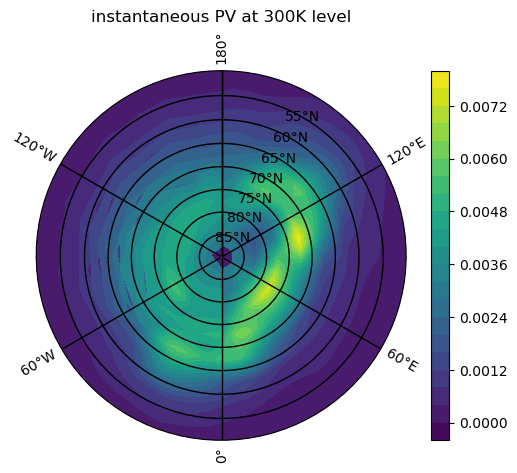

In [3]:
timeind = -1
isenind = 4
latind = 10
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth = 1, linestyle = '-', color = 'black', alpha = 1, draw_labels=True)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180,180,50,90], crs=ccrs.PlateCarree())
#ds.PV[200,2].plot(ax=ax, transform=ccrs.PlateCarree(), cmap = 'viridis')
plot = ax.contourf(d_isentropic.PV[timeind, isenind, :].lon, d_isentropic.PV[timeind, isenind, :].lat,
            d_isentropic.PV[timeind, isenind, :], transform = ccrs.PlateCarree(), levels = 21)
plt.colorbar(plot, ax = ax)
plt.title('instantaneous PV at %.0fK level' %(d_isentropic.level.values[isenind]))
#plt.savefig('/home/links/sh1293/Reanalysis/newplot.png', bbox_inches = 'tight')

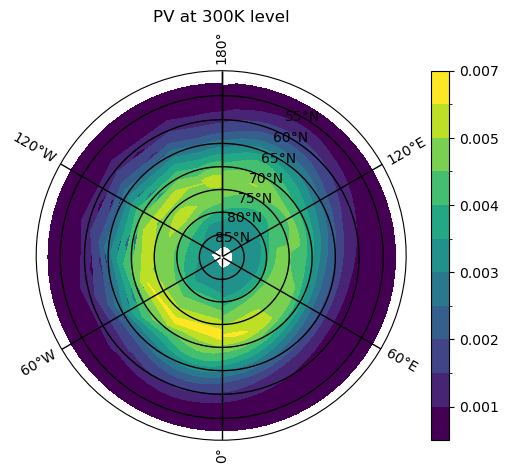

In [10]:
ds = d_isentropic
x = ds.sel(lat=ds.lat[50<ds.lat])
time_average = x.mean(dim = 'time')


def make_colourmap(vmin, vmax, step, **kwargs):
    '''
    Makes a colormap from ``vmin`` (inclusive) to ``vmax`` (exclusive) with
    boundaries incremented by ``step``. Optionally includes choice of color and
    to extend the colormap.
    '''
    col = kwargs.pop('col', 'viridis')
    extend = kwargs.pop('extend', 'both')

    boundaries = list(np.arange(vmin, vmax, step))

    if extend == 'both':
        cmap_new = cm.get_cmap(col, len(boundaries) + 1)
        colours = list(cmap_new(np.arange(len(boundaries) + 1)))
        cmap = colors.ListedColormap(colours[1:-1],"")
        cmap.set_over(colours[-1])
        cmap.set_under(colours[0])

    elif extend == 'max':
        cmap_new = cm.get_cmap(col, len(boundaries))
        colours = list(cmap_new(np.arange(len(boundaries))))
        cmap = colors.ListedColormap(colours[:-1],"")
        cmap.set_over(colours[-1])

    elif extend == 'min':
        cmap_new = cm.get_cmap(col, len(boundaries))
        colours = list(cmap_new(np.arange(len(boundaries))))
        cmap = colors.ListedColormap(colours[1:],"")
        cmap.set_under(colours[0])

    norm = colors.BoundaryNorm(boundaries, ncolors = len(boundaries) - 1,
                               clip = False)

    return boundaries, cmap_new, colours, cmap, norm


vmin = 0.001
vmax = 0.006
step = 0.0005

boundaries0, _, _, cmap0, norm0 = make_colourmap(vmin, vmax, step,
                                                col = 'viridis', extend = 'both')


isenind = 4
latind = 8
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth = 1, linestyle = '-', color = 'black', alpha = 1, draw_labels=True)
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180,180,50,90], crs=ccrs.PlateCarree())
#time_average.PV[200,2].plot(ax=ax, transform=ccrs.PlateCarree(), cmap = 'viridis')
plot = ax.contourf(time_average.PV[isenind, :].lon, time_average.PV[isenind, :].lat,
            time_average.PV[isenind, :], transform = ccrs.PlateCarree(), cmap = cmap0,
                   levels = [-0.1]+boundaries0+[0.007], norm = norm0)
plt.title('PV at %.0fK level' %(time_average.level.values[isenind]))
plt.colorbar(plot, ax=ax)

In [8]:
boundaries0

[0.001,
 0.0015,
 0.002,
 0.0025,
 0.003,
 0.0035,
 0.004,
 0.0045000000000000005,
 0.005,
 0.0055000000000000005]

In [50]:
float(np.min(time_average.PV[isenind, :]).values)

0.0001495798714778414

In [3]:
calculate_PV

<xarray.Dataset>
Dimensions:  (time: 360, plev: 40, lat: 36, lon: 73, pfull: 40)
Coordinates:
  * time     (time) float32 5.881e+03 5.881e+03 ... 5.911e+03 5.911e+03
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 360.0
  * pfull    (pfull) float64 0.1 0.6 1.1 1.6 2.1 ... 450.0 500.0 550.0 600.0
Dimensions without coordinates: plev
Data variables:
    temp     (time, plev, lat, lon) float64 182.0 181.7 181.5 ... nan nan nan
    ucomp    (time, plev, lat, lon) float64 60.64 65.23 70.84 ... nan nan nan
    vcomp    (time, plev, lat, lon) float64 64.52 67.89 70.62 ... nan nan nan

In [4]:
prs

<xarray.DataArray (time: 360, lev: 35, lat: 36, lon: 73)>
array([[[[6.62800964e+02, 6.61775452e+02, 6.60641418e+02, ...,
          6.64413574e+02, 6.63688538e+02, 6.43990356e+02],
         [8.17097534e+02, 8.12535950e+02, 8.07728394e+02, ...,
          8.24641296e+02, 8.21208740e+02, 7.55353027e+02],
         [8.63362488e+02, 8.60668091e+02, 8.60183899e+02, ...,
          8.73411194e+02, 8.67908386e+02, 8.48125671e+02],
         ...,
         [5.05212433e+02, 5.06357239e+02, 5.07253510e+02, ...,
          5.02288086e+02, 5.03821747e+02, 5.38922913e+02],
         [4.97086670e+02, 4.96856995e+02, 4.97121552e+02, ...,
          4.98546661e+02, 4.97686066e+02, 5.06727570e+02],
         [4.86907104e+02, 4.87331299e+02, 4.87724579e+02, ...,
          4.85958405e+02, 4.86450409e+02, 4.59905396e+02]],

        [[6.61969910e+02, 6.60945679e+02, 6.59813049e+02, ...,
          6.63580505e+02, 6.62856384e+02, 6.43182861e+02],
         [8.16072998e+02, 8.11517151e+02, 8.06715637e+02, ...,
          8.23607300e+02, 8.20179016e+02, 7.54405884e+02],
         [8.62279968e+02, 8.59588867e+02, 8.59105286e+02, ...,
          8.72316040e+02, 8.66820129e+02, 8.47062256e+02],
...
          9.32393447e-02, 9.35466066e-02, 1.00751236e-01],
         [9.20910165e-02, 9.20675024e-02, 9.21390951e-02, ...,
          9.23369527e-02, 9.21873376e-02, 9.37673971e-02],
         [9.02865529e-02, 9.03697684e-02, 9.04464126e-02, ...,
          9.00995955e-02, 9.01966318e-02, 8.50238204e-02]],

        [[3.45686115e-02, 3.45302895e-02, 3.44856828e-02, ...,
          3.46212089e-02, 3.45992781e-02, 3.35059799e-02],
         [4.23622541e-02, 4.21789736e-02, 4.19722162e-02, ...,
          4.26152870e-02, 4.25106436e-02, 3.86398733e-02],
         [4.39893343e-02, 4.39474657e-02, 4.39977013e-02, ...,
          4.42426801e-02, 4.41021211e-02, 4.20527644e-02],
         ...,
         [2.43805498e-02, 2.44501922e-02, 2.45087985e-02, ...,
          2.42225770e-02, 2.43024006e-02, 2.61740852e-02],
         [2.39242539e-02, 2.39181444e-02, 2.39367429e-02, ...,
          2.39881445e-02, 2.39492767e-02, 2.43597589e-02],
         [2.34554727e-02, 2.34770905e-02, 2.34970041e-02, ...,
          2.34069042e-02, 2.34321132e-02, 2.20882725e-02]]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 170.0 175.0 360.0
  * lat      (lat) float32 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * time     (time) float32 5.881e+03 5.881e+03 ... 5.911e+03 5.911e+03
  * lev      (lev) float32 0.9995 0.9982 0.9964 ... 0.0001956 5.082e-05